## Import libraries and Data

In [167]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

sns.set_theme()

In [2]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)

del df

In [3]:
split_date = '2023-05-31'

df_train = df_coffee[df_coffee['Date']<=split_date].copy()
df_test = df_coffee[df_coffee['Date'] > split_date].copy()

## Box Cox Transform Model

In [4]:
scaler_bc = StandardScaler()

In [5]:
df_coffee_bc_scaled = df_train.copy()

df_coffee_bc_scaled['Quantity_BC_Transform'], lam = boxcox(df_coffee_bc_scaled['Quantity'])
df_coffee_bc_scaled['Quantity_BC_Scaled'] = scaler_bc.fit_transform(df_coffee_bc_scaled[['Quantity_BC_Transform']])
df_coffee_bc_scaled['Difference'] = df_coffee_bc_scaled['Quantity_BC_Scaled'].diff()


In [6]:
df_coffee_bc_scaled

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference
0,2023-01-01,375,1.267371,-0.572682,NaN
1,2023-01-02,376,1.267397,-0.561042,0.011640
2,2023-01-03,365,1.267105,-0.692201,-0.131159
3,2023-01-04,337,1.266285,-1.060231,-0.368030
4,2023-01-05,346,1.266562,-0.936155,0.124076
...,...,...,...,...,...
146,2023-05-27,747,1.272564,1.758813,-0.020366
147,2023-05-28,689,1.272090,1.545757,-0.213056
148,2023-05-29,550,1.270597,0.875576,-0.670181
149,2023-05-30,617,1.271391,1.232200,0.356623


###  Model Development

In [118]:
aic = []
bic = []
rsquared_adj = []

model_test = df_coffee_bc_scaled.copy()
time_lag(model_test,'Difference',steps=31)
model_test= model_test.dropna()

for step in list(range(30)):
    
    f = []
    for i in list(range(step+1)):
        f.append(f't-{i+1}')

    target = model_test['Difference']
    features = model_test[f]
    features = sm.add_constant(features)

    bc_scaled_mlr_model = sm.OLS(target,features).fit()

    aic.append(bc_scaled_mlr_model.aic)
    bic.append(bc_scaled_mlr_model.bic)
    rsquared_adj.append(bc_scaled_mlr_model.rsquared_adj)


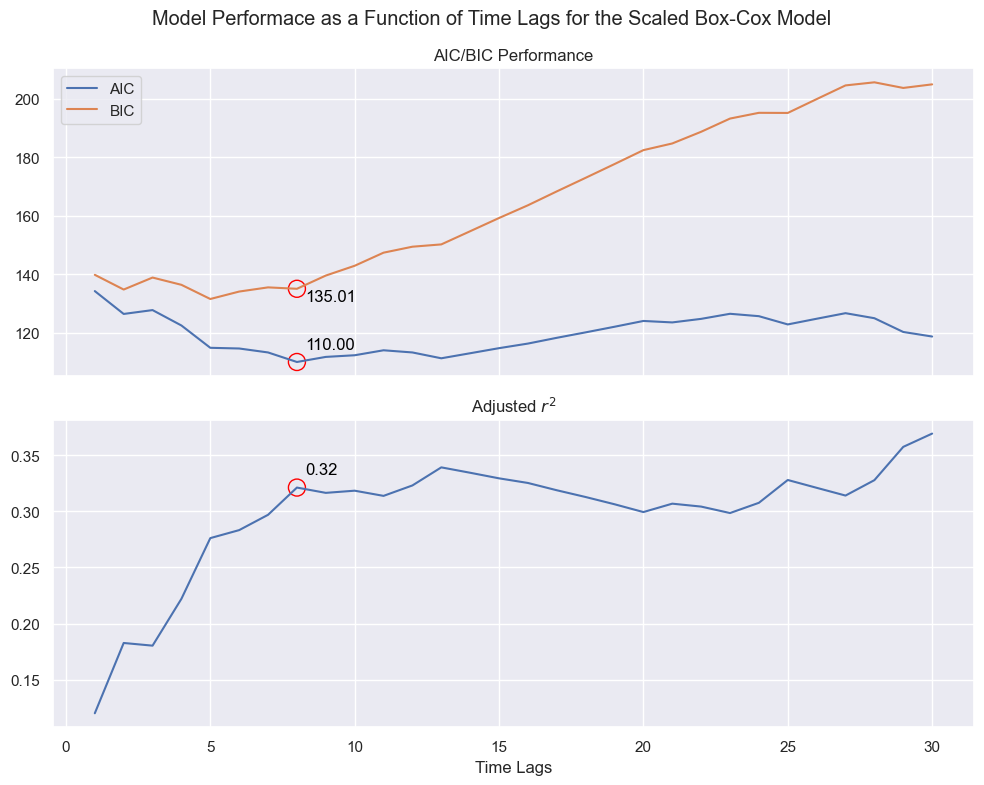

In [166]:
fig, ax = plt.subplots(2,1, figsize = (10,8),sharex=True)

lags = range(1, 31)

sns.lineplot(x= lags, y=aic, ax=ax[0],label='AIC')
sns.lineplot(x=lags, y= bic, ax=ax[0],label='BIC')
sns.lineplot(x=lags, y=rsquared_adj,ax=ax[1])

x_val = 8

y_aic = aic[x_val-1]
y_bic = bic[x_val-1]
y_r2  = rsquared_adj[x_val-1]

ax[0].scatter(x_val, y_aic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[0].scatter(x_val, y_bic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[1].scatter(x_val, y_r2,  s=150, facecolors='none', edgecolors='red', linewidths=1)

ax[0].text(x_val+0.3, y_aic+4.5, f"{y_aic:.2f}", color='black')
ax[0].text(x_val+0.3, y_bic, f"{y_bic:.2f}", color='black',va='top')
ax[1].text(x_val+0.3, y_r2+0.012,  f"{y_r2:.2f}", color='black')

fig.suptitle("Model Performace as a Function of Time Lags for the Scaled Box-Cox Model")
ax[0].set(title="AIC/BIC Performance")
ax[1].set(title='Adjusted $r^2$',xlabel = "Time Lags")


plt.tight_layout()
plt.savefig("Images/Model_performance_by_lags.png")

plt.show()

In [145]:
idx = 8

model_df = df_coffee_bc_scaled.copy()
time_lag(model_df,'Difference',steps=idx)
model_df = model_df.dropna()

target = model_df['Difference']

f = []
for i in range(1,8+1):
    f.append(f't-{i}')

features = model_df[f]

features = sm.add_constant(features)

bc_scaled_mlr_model = sm.OLS(target,features).fit()

bc_scaled_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     9.154
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           5.58e-10
Time:                        00:40:08   Log-Likelihood:                -69.900
No. Observations:                 142   AIC:                             157.8
Df Residuals:                     133   BIC:                             184.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0735      0.035      2.070      0.040       0.003       0.144
t-1           -0.6391      0.084     -7.567      0.000      -0.806      -0.472
t-2           -0.4757      0.097     -4.884      0.000      -0.668      -0.283
t-3           -0.3820      0.104     -3.676      0.000      -0.587      -0.176
t-4           -0.4920      0.101     -4.854      0.000      -0.692      -0.292
t-5           -0.5008      0.101     -4.939      0.000      -0.701      -0.300
t-6           -0.2875      0.104     -2.765      0.007      -0.493      -0.082
t-7           -0.2572      0.099     -2.610      0.010      -0.452      -0.062
t-8           -0.1620      0.085     -1.902      0.059      -0.331       0.006
==============================================================================
Omnibus:                        1.289   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.122
Skew:                           0.218   Prob(JB):                        0.571
Kurtosis:                       3.003   Cond. No.                         5.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [173]:
residuals = bc_scaled_mlr_model.resid
resid_std = (residuals - residuals.mean()) / residuals.std()

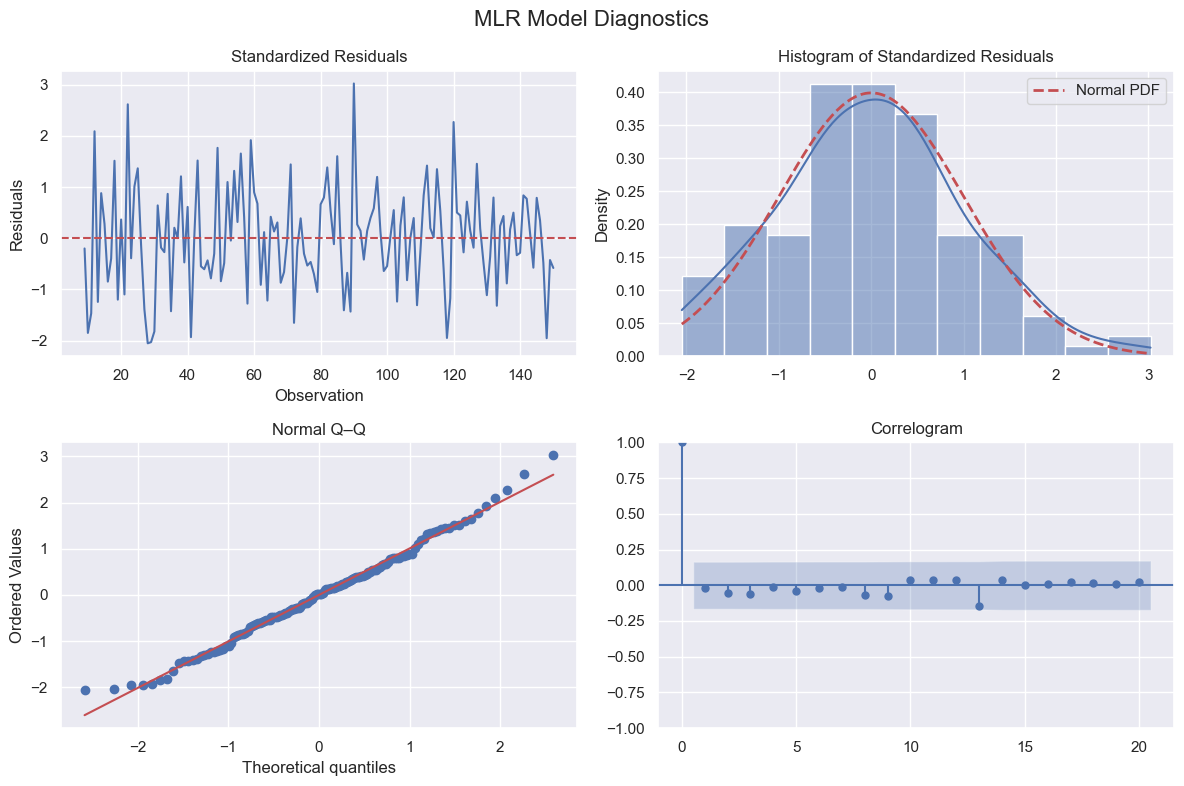

In [187]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MLR Model Diagnostics", fontsize=16)

#Residuals
axes[0, 0].plot(resid_std, linestyle='-')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Standardized Residuals")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Residuals")

#Histogram
sns.histplot(resid_std, kde=True, stat="density", ax=axes[0, 1])

x = np.linspace(resid_std.min(), resid_std.max(), 200)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r--', linewidth=2, label="Normal PDF")
axes[0, 1].legend()
axes[0, 1].set_title("Histogram of Standardized Residuals")

#Q–Q plot
stats.probplot(resid_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q")

#ACF plot
plot_acf(resid_std, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("Correlogram")

plt.tight_layout()

plt.savefig('Images/MLR_Model_Diagnostics.png')

plt.show()

### Testing